# Сегментация пятен нефти на поверхности водоёмов

В рамках данного ноутбука в коде повторён процесс работы с фреймворком Roboflow*.

*За исключением процесса предобработки и аугментации данных, а также деплоя модели.

<details>
    <summary></summary>
        <sub>Нам за это не платили</sub>
</details>

## Установка необходимых зависимостей

Для успешного обучения модели и проведения к ней запроса нам необходимо установить следующие зависимости:
- roboflow - для взаимодействия с проектом на roboflow
- ultralytics - для взаимодействия с моделью Yolo
- inference - для взаимодейтсвия с сервером, на котором развёрнут pipeline roboflow

In [17]:
!pip install roboflow ultralytics inference

## Импортируем все необходимые модули

Отдельно отметим, что на этапе запроса к модели будут использоваться неразмеченные данные из другого датасета.

Для того, чтобы получить доступ к этим данным, была произведена их выгрузка на личный google drive, после чего он был подмаунчен к данному блокноту в среде colab.


In [18]:
from roboflow import Roboflow
import os
from ultralytics import YOLO
from google.colab import drive
import os
from inference_sdk import InferenceHTTPClient
import matplotlib.pyplot as plt
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Загрузка датасета для обучения модели

Загрузка подготовленных предобработанных аугментированных данных осуществляется при помощи работы с объектом Roboflow из библиотеки roboflow.

Указываем актуальные параметры проекта, версию и модель (Yolo V11)

In [19]:
rf = Roboflow(api_key="Ehyo1xfnKBt9v6GR9kyf")
project = rf.workspace("pfohack").project("oil-8sfgp-rektk")
version = project.version(4)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to OIL-4 in yolov11:: 100%|██████████| 420/420 [00:00<00:00, 5169.72it/s]


## Обучение модели

Модель обучается 30 эпох, в качестве регуляризатора используется Adam (L2 регуляризация весов на каждом шаге обучения);

In [20]:
model = YOLO(model="yolo11n.yaml")
results = model.train(data=f'{dataset.location}/data.yaml',
                      epochs=30,
                      imgsz=640,
                      optimizer='Adam',
                      seed=0,
                      lr0=0.001)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=/content/OIL-4/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 24.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.3MB/s]


AMP: checks passed ✅


train: Scanning /content/OIL-4/train/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 1415.96it/s]

train: New cache created: /content/OIL-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/OIL-4/valid/labels... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<00:00, 692.11it/s]

val: New cache created: /content/OIL-4/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.58G      3.316      3.393      4.157         66        640: 100%|██████████| 11/11 [00:05<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all         21         45    0.00397      0.556     0.0104    0.00316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.39G      3.135      3.309      3.788         55        640: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         21         45    0.00349      0.489     0.0085    0.00249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.39G      3.197      3.239      3.672         37        640: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         21         45    0.00333      0.467    0.00885    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.39G      3.171      3.171      3.566         56        640: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         21         45    0.00349      0.489     0.0121    0.00361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.36G      3.216      3.093      3.543         46        640: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         45    0.00349      0.489     0.0187    0.00511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.38G      3.158      3.021      3.497         54        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         45    0.00349      0.489     0.0228    0.00574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.38G      3.205      2.977      3.494         55        640: 100%|██████████| 11/11 [00:03<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         21         45    0.00397      0.556      0.102     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.39G      3.085      2.936      3.469         41        640: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         21         45    0.00397      0.556      0.129      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.37G      3.062      2.928      3.403         35        640: 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         45    0.00397      0.556      0.148     0.0476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.39G      3.011      2.879      3.387         43        640: 100%|██████████| 11/11 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         21         45     0.0289      0.422       0.14      0.064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.38G      2.948      2.843      3.357         39        640: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         21         45     0.0646      0.356      0.142     0.0761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.39G      2.885      2.803      3.329         45        640: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         21         45    0.00302      0.422     0.0172    0.00513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.38G       2.79      2.805      3.261         52        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         21         45    0.00397      0.556      0.194     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.39G      2.763       2.71      3.203         40        640: 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         21         45      0.163      0.333      0.193      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.39G      2.724      2.733      3.192         52        640: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         21         45      0.348      0.244      0.224     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.39G      2.622      2.655      3.112         58        640: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         21         45      0.482      0.244      0.248       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.38G      2.619      2.695      3.092         64        640: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         21         45      0.317      0.196      0.128      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.39G      2.686      2.659      3.128         52        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         21         45      0.358      0.267      0.217     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.38G      2.605      2.665      3.045         42        640: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         21         45      0.447      0.269      0.255     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.39G      2.494      2.572      2.969         52        640: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         21         45      0.593      0.259      0.255     0.0905


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.42G      2.561      3.145      3.119         17        640: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         21         45      0.721      0.311      0.307      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.38G       2.45       2.92      3.068         13        640: 100%|██████████| 11/11 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         21         45      0.678      0.311      0.296     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.37G      2.454      2.756      3.061         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         21         45       0.58      0.289      0.277      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.35G       2.33      2.744      3.023         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         21         45      0.555      0.267      0.278      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.36G      2.418      2.661      3.046         16        640: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         21         45       0.64      0.289      0.291      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.37G      2.357      2.626      3.005         16        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         21         45       0.65      0.289      0.319      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.38G      2.343      2.617      2.979         21        640: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         21         45      0.705      0.311      0.338      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.37G      2.336      2.606      2.991         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         21         45      0.633      0.333      0.341      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.37G      2.351      2.583      2.983         27        640: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         21         45      0.683      0.289      0.333      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.37G      2.257      2.583      2.901         18        640: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         21         45      0.682      0.289      0.329      0.128



30 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


                   all         21         45      0.683      0.289      0.335      0.129
Speed: 0.5ms preprocess, 3.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


Посел того, как модель обучилась, в output мы можем видеть метрики на тестовой, валидационной и обчающей выборке.

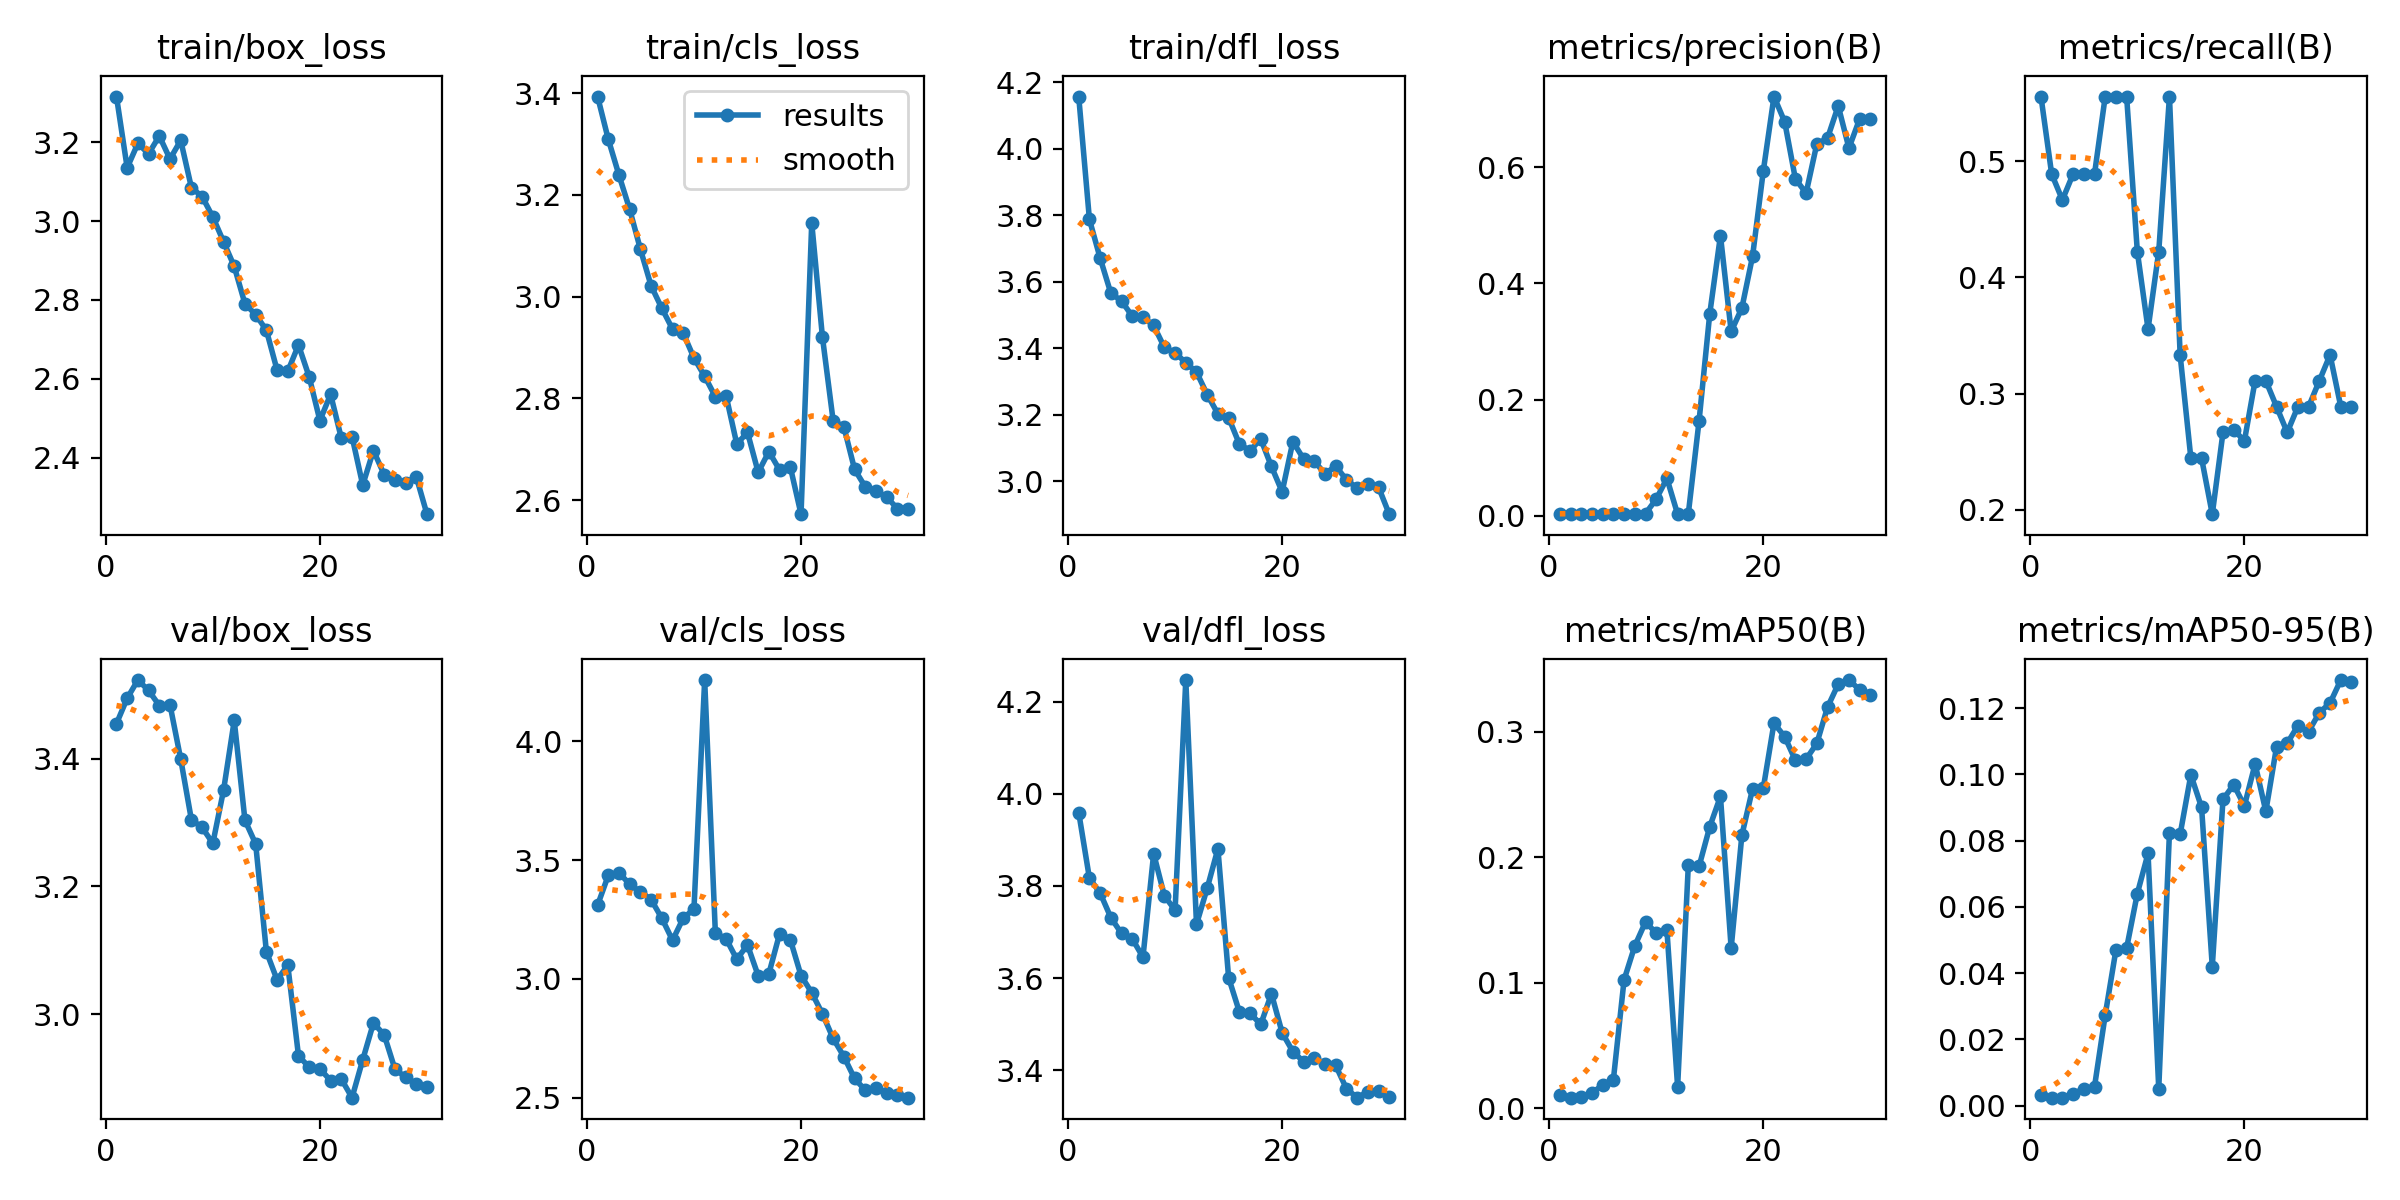

In [30]:
from IPython.display import Image
results_img = 'runs/detect/train/results.png'
Image(filename=results_img)

## Запрос к модели

Запрос осуществляется к аналогичной модели, развёрнутой на roboflow в виде workflow.

Workflow состоит из 3-х элементов:
- input
- model
- output

Данный развёрнутый workflow позвоялет посылать к модели запросы и получать в качестве ответа json с прогнозом.

### Данные для запроса

Приведём пример изображения, которое планируется посылать к модели

['1771_png.rf.ec45ba2f4bcbcff89d0676cc332574ba.jpg', '918_png.rf.d95bcf61989bebb0319c9e80ec0dcfe1.jpg', '948_png.rf.105b0048917552c96b81c48b5152db00.jpg', '922_png.rf.ae66b448ce6660b115680149f565cd53.jpg', '904_png.rf.c505c52bf349e0bec07bc237a54255d9.jpg', '939_png.rf.f640ef39eb5ad8a4627ddd12b4ba1977.jpg', '1787_png.rf.22a58cb4e6f583107eb51f9f78ca4a8e.jpg', '1789_png.rf.515a94938261cde036839ea3358f2031.jpg', '1780_png.rf.6565fde52873c9cdceac7c918a091710.jpg', '950_png.rf.e884549a62752d1930a082df4983497e.jpg', '940_png.rf.00974f0e1c8942c5e46f2cb50e4f0bd8.jpg', '610_png.rf.aa09037609823143f95b529b5e490612.jpg', '1732_png.rf.6c96a9e16e66821424c472debcf5ce1d.jpg', '1739_png.rf.0841943bcc945e69ea742f9ce3f46626.jpg', '321_png.rf.b3342d9a8cbf65822f56831fbed6b38f.jpg', '327_png.rf.fab4692bd401945ab7d7312cd4a7d884.jpg', '435_png.rf.1b56e6f0297d991f6dab01bd2d2a7ca1.jpg', '1762_png.rf.a3220c62b55c215bfc36c1fc80e3fd89.jpg', '927_png.rf.45b07f079b1832c27ffefc8fa06b03d7.jpg', '935_png.rf.dc6d1249d41

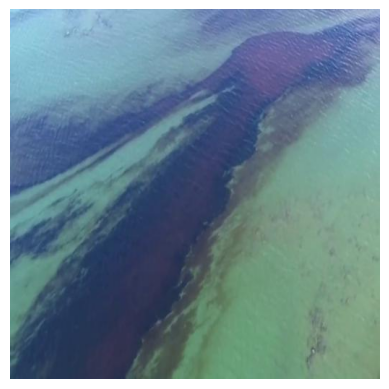

In [22]:
folder_path = '/content/drive/My Drive/oil22-1/train (1)/oil2'
images = os.listdir(folder_path)
print(images)
image_path = folder_path + "/435_png.rf.1b56e6f0297d991f6dab01bd2d2a7ca1.jpg"
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


### Запрос

Запрос осуществляется с использованием объекта `InferenceHTTPClient`, который позволяет нам получить доступ к задеплоенному workflow.

In [40]:
client = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="Ehyo1xfnKBt9v6GR9kyf"
)

result = client.run_workflow(
    workspace_name="pfohack",
    workflow_id="custom-workflow-3",
    images={
        "image": image_path
    },
    use_cache=True
  )# cache workflow definition for 15 minutes

for key, value in result[0]["predictions"]["predictions"][0].items():
    print(f"{key}: {value}")

width: 497.0
height: 494.0
x: 249.5
y: 263.0
confidence: 0.7402244806289673
class_id: 0
class: 0
detection_id: c5695d1f-26a5-4718-a3ed-d0aa46140218
parent_id: image


В output видим геометрические характеристики прямоугольника, в рамке которого модель обнаружила нефтяное пятно